In [1]:
import numpy as np
from numpy import linalg as la
from os import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import autograd
from math import *
%matplotlib inline

### Cross-well Tomography.
Inverse problems are problems where we seek to measure the parameters
of a physical system from measurements of its response to one or more inputs. This is in contrast to
forward problems where, given a physical system, we seek to determine its response to a given input.
Consider, as an example, the following cross-well tomography problem used in petroleum exploration.
Two vertical wells are located 1600m apart. A seismic source is inserted in one of the wells at depths of
50; 150; 1550 m. A string of receivers is inserted in the other well at depths of 50; 150; 1550m as
shown in the gure below. For each source-receiver pair a travel time is recorded (such measurements,
while accurate, have an error on the order of 0:5 ms). There are 256 ray paths and 256 corresponding
measurements. We wish to determine the velocity structure in the two-dimensional plane between the
two wells.

In [2]:
d=np.load('d.npy')
G=np.load('G.npy')
print("The condition number of G is {}.".format(la.cond(G)))

The condition number of G is 1.027499756939212e+19.


We can't solve the system $\mathbf{G} \mathbf{x} = \mathbf{d}$ since we lose $\log_{10} \kappa = \log_{10} 1.02\times10^{19} \approx 19$ digits in accuracy.

In [5]:
eig=la.eig(G)

In [4]:
#check if the matrix is positive definite
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)
is_pos_def(G)

False

In [6]:
np.abs(np.max(eig[0])-np.min(eig[0]))
#not sure what does it mean to have complex eigen values

1937.1811102386976

In [7]:
#we can also check the determinant of the matrix
la.det(G)

0.0

In [8]:
if la.cond(G) < 1/sys.float_info.epsilon:
    i = la.inv(G)
else:
    print('Ill-conditioned Matrix')

Ill-conditioned Matrix


## Formulating as Linear Least Squares

We use the mean squared error: $E(x) = \Vert Gx - d \Vert^2 = (Gx-d)^\top (Gx-d)$. The optimization problem at hand is:

\begin{equation}
\begin{aligned}
\min_x & & (Gx-d)^\top (Gx-d) \\
\end{aligned}
\end{equation}

We compute the gradient and find that $\nabla E(x) = 2 G^\top (Gx-d)$. Setting the gradient to 0, we obtain the following system that needs to be solved to obtain $x^*$.
$$G^\top G x^* = G^\top d$$

In [5]:
#Least Squares formulation x=((AA')^-1)A'y
def solve_cw(G, d, alpha = 0):
    # setting alpha to 0 gives us linear least squares as usual
    
    GtG = np.matmul(G.T, G) + alpha * np.eye(G.shape[0])
    Gtd = np.matmul(G.T, d)
    x_opt = la.solve(GtG, Gtd)
    
    return x_opt
x_opt = solve_cw(G, d)
print("Mean Squared Error: {}.".format(la.norm(G.dot(x_opt) - d)))
#x=la.inv(np.transpose(G)@G)@np.transpose(G)@d

LinAlgError: Singular matrix

## Formulating as Regularized Linear Least Squares

We now formulate the problem as regularized linear least squares:

\begin{equation}
\begin{aligned}
&\min_x & (Gx-d)^\top (Gx-d) + \alpha \cdot x^\top x\\
& \text{s.t.} & 10^{-6} \leq \alpha \leq 10^6
\end{aligned}
\end{equation}

The new gradient $\nabla E'(x) = 2\, \left( G^\top (Gx-d) + \alpha \cdot x \right) = 2\, \left[ \left(G^\top G + \alpha \cdot I \right) x - G^\top d \right]$. By setting to 0, we get that the system that needs to be solved is:

$$(G^\top G + \alpha \cdot I) \, x = G^\top d$$

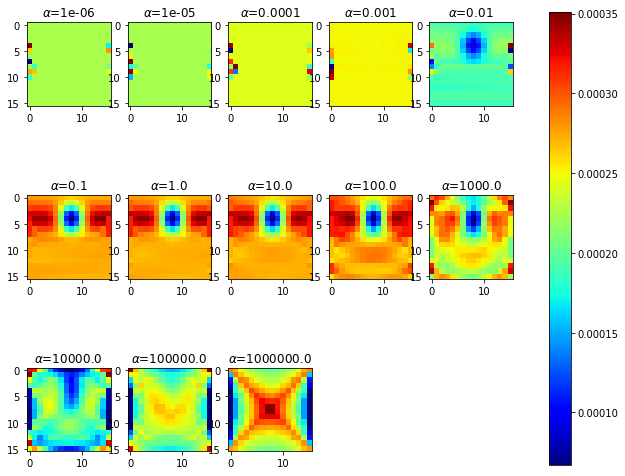

In [8]:
#tikhonov regularization
#as we increase alpha we shift the matrix from region where it is illconfitioned
#as the alpha gets very large the problem is changed and the input dominates over the actual problem.
#how to chose the best depends on the domain knowledge to chose what is reasonable.
plt.rcParams["figure.figsize"] = "10,9"
fig = plt.figure()
alphas = np.logspace(-6, 6, 13)
for i in range(len(alphas)):
    x1=la.inv(np.transpose(G)@G+np.diag(np.ones(len(G)))*alphas[i])
    x=x1@np.transpose(G)@d
    a=fig.add_subplot(3,5,i+1)
    a.set_title(r'$ \alpha $='+str(alphas[i]))
    x=x.reshape(16,16)
    im=plt.imshow(x,cmap='jet')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)



The best value of alpha is to be determined by field experts by inspecting the tomography. The reasonable graphs correspond to $0.1 \leq \alpha \leq 10$ since they don't contain much noise, yet they somehow reflect some properties of the underground.

## Using Singular Value Decomposition


We first find the SVD decompostion of $G$, i.e. $G = U S V^\top$

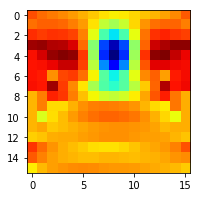

In [11]:
# svd decomposition and truncate the small singular values
plt.rcParams["figure.figsize"] = "3,3"
h = la.pinv(G,rcond=5*1e-3) # 
x=h@d
x=x.reshape(16,16)
im=plt.imshow(x,cmap='jet')

In [9]:
U, S, V = la.svd(G)

In [17]:
x_opt = 0
for i in range(len(S[:-20])):
    x_opt += U[i].dot(d) / S[i] * V[i]
print('Error using SVD truncation',la.norm(G.dot(x_opt) - d))

Error using SVD truncation 13.110882273863458


# Problem 2 - System of Non-Linear Equations

Consider the system of non linear equations:

\begin{equation}
\begin{cases}
\frac{2x_1 + x_2}{\left( 1 + (2x_1 + x_2)^2\right)^{1/2}} = 0 \\
\frac{2x_1 - x_2}{\left( 1 + (2x_1 - x_2)^2\right)^{1/2}} = 0
\end{cases}
\end{equation}

Let $\mathbf{f}: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ be defined as:
$$\mathbf{f}(\mathbf{x}) = \begin{pmatrix} f_1(\mathbf{x}) \\ f_2(\mathbf{x}) \end{pmatrix} = \begin{pmatrix} \frac{2x_1 + x_2}{\left( 1 + (2x_1 + x_2)^2\right)^{1/2}} \\ \frac{2x_1 - x_2}{\left( 1 + (2x_1 - x_2)^2\right)^{1/2}} \end{pmatrix}$$

where $\mathbf{x} = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \in \mathbb{R}^2$. We can then solve the equation $\mathbf{f}(\mathbf{x}) = \mathbf{0}$ to get the solution $\mathbf{x}^*$.

In [19]:
import sympy as sp
# symbic function and its jacobian
x1 = sp.Symbol('x1')
x2 = sp.Symbol('x2')
x = np.array([x1, x2])
f_symb1=(2*x[0]+x[1])/(1+(2*x[0]+x[1])**2)**.5
f_symb2=(2*x[0]-x[1])/(1+(2*x[0]+x[1])**2)**.5

F = sp.Matrix([f_symb1,f_symb2])
J=F.jacobian(x)
F_true=sp.lambdify([x], F, 'numpy')
J_true=sp.lambdify([x], J, 'numpy')

In [13]:
# the jacobian is singular matrix
#implementation of a basic Newton's Method
a=np.array([0.3,0.3])
history=a
while(la.norm(F_true(a)) > 1e-6):
    inv=la.pinv(np.transpose(J_true(a))@J_true(a),rcond=1e-20)
    d_x=-inv@np.transpose(J_true(a))@F_true(a)
    a=a+d_x.reshape(-1)
    history = np.vstack( (history, a) )

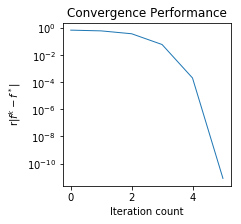

In [14]:
nsteps = history.shape[0]
fhist = np.zeros(nsteps)
for i in range(nsteps):
    fhist[i] = la.norm(F_true(history[i]))
plt.figure()

plt.semilogy(np.arange(0, nsteps), fhist, linewidth=1)
plt.title('Convergence Performance')
plt.xlabel('Iteration count')
plt.ylabel('r$|f^k - f^*|$')
plt.show()

#### Part2

In [22]:
a=np.array([0.5,0.5])
history=a
while(la.norm(F_true(a)) > 1e-6):
    inv=la.pinv(J_true(a),rcond=1e-20)
   
    d_x=-inv@F_true(a)
    a=a+d_x.reshape(-1)
    history = np.vstack( (history, a) )
    #from the first values of a it is clear that the algorithm diverging

KeyboardInterrupt: 

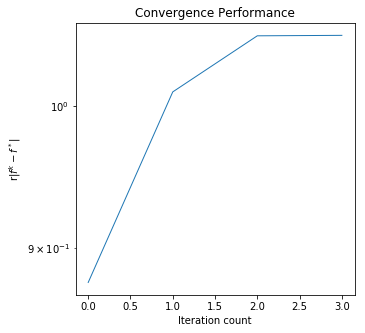

In [289]:
nsteps = history[0:4].shape[0]
fhist = np.zeros(nsteps)
for i in range(nsteps):
    fhist[i] = la.norm(F_true(history[i]))
plt.figure()

plt.semilogy(np.arange(0, nsteps), fhist, linewidth=1)
plt.title('Convergence Performance')
plt.xlabel('Iteration count')
plt.ylabel('r$|f^k - f^*|$')
plt.show()

### Part4 globalize newton method using merit function

In [29]:
def merit_func(f,x):
    return .5*np.transpose(f(x))@f(x).reshape(-1)

def backtrack_linesearch(F_true,merit_func, gk, pk, xk, alpha = 0.1, beta = 0.8):
    t = 1
    while ( merit_func(F_true,xk + t*pk) >= merit_func(F_true,xk) + alpha * t * gk @ pk ):
        t *= beta
    return t

In [38]:
# a=np.array([0.5,0.5])
# history=a
# while(la.norm(F_true(a)) > 1e-6):
#     inv=la.pinv(J_true(a),rcond=1e-20)
#     p=-inv@F_true(a)
#     p=p.reshape(-1)
#     t = backtrack_linesearch(F_true,merit_func, np.transpose(J_true(a))@F_true(a).reshape(-1), p, a)
#     a=a+t*p
#     history = np.vstack( (history, a) )
a=np.array([0.5,0.5])
history=a
while(la.norm(F_true(a)) > 1e-6):
    inv=la.pinv(np.transpose(J_true(a))@J_true(a),rcond=1e-20)
    p=-inv@np.transpose(J_true(a))@F_true(a)
    p=p.reshape(-1)
    t = backtrack_linesearch(F_true,merit_func,J_true(a)@F_true(a).reshape(-1), p, a)
    a=a+t*p
    history = np.vstack( (history, a) )

array([0.51071879])

In [36]:
(J_true(a)@F_true(a)).shape

(2, 1)

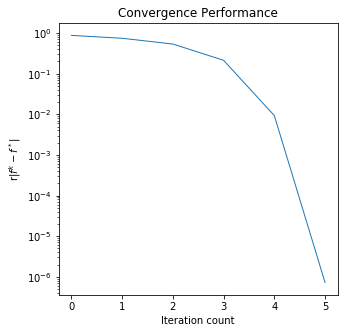

In [338]:
nsteps = history.shape[0]
fhist = np.zeros(nsteps)
for i in range(nsteps):
    fhist[i] = la.norm(F_true(history[i]))
plt.figure()

plt.semilogy(np.arange(0, nsteps), fhist, linewidth=1)
plt.title('Convergence Performance')
plt.xlabel('Iteration count')
plt.ylabel('r$|f^k - f^*|$')
plt.show()

# Catenary Equation

The system at hand can be described by the following non-linear differential equation:
$$\frac{d^2 u}{dx^2} = c \sqrt{1 + \left( \frac{du}{dx} \right)^2} $$
where $u(x)$ is the vertical height about a point $x$ between the 2 poles. To solve this problem numerically, we discretize the horizontal axis between the 2 poles into N bins. Let $\mathbf{x} = \begin{pmatrix} x_0 \\ \vdots \\ x_{n-1} \end{pmatrix}$ be a vector representing interior points separarting 2 neighboring cells. We need to find the optimal heights $\mathbf{u}(\mathbf{x}) = \begin{pmatrix} u(x_0) \\ \vdots \\ u(x_{n-1}) \end{pmatrix} = \begin{pmatrix} u_0 \\ \vdots \\ u_{n-1} \end{pmatrix}$. Let the vector function $\mathbf{f}: \mathbb{R}^n \rightarrow \mathbb{R}^n$ be defined as:
$$\mathbf{f} (u) = c \sqrt{1 + \left( \frac{du}{dx} \right)^2} - \frac{d^2 u}{dx^2}$$

By discretization we can approximate the first and second derivative by:

\begin{cases}
\frac{du}{dx} = \frac{1}{2h} \left( u_{i+1} - u_{i-1} \right) \\
\\ 
\frac{d^2 u}{dx^2} = \frac{1}{h^2} \left( u_{i+1} - 2u_i + u_{i-1} \right)
\end{cases}

Finally we try to find a root of $\mathbf{f} (\cdot)$ as a solution to the above system.

In [64]:
def catenary(u):
    #using the canonical form
    c=0.5
    l=2
    r=3
    N=len(u+2)
    h=5/N
    #d=np.linspace(0,5,N)
    f=autograd.numpy.zeros((len(u)))
    f=autograd.builtins.list(f)
    for i in range(len(u)):
        if i==0:
           
            f[i]=1/(-h**2)*(-l+2*u[i]-u[i+1])-c*autograd.numpy.sqrt(1+(1/(2*h)*(u[i+1]-l))**2)
        elif i==len(u)-1:
            f[i]=1/(-h**2)*(-u[i-1]+2*u[i]-r)-c*autograd.numpy.sqrt(1+(1/(2*h)*(r-u[i-1]))**2)
        else:
            f[i]=1/(-h**2)*(-u[i-1]+2*u[i]-u[i+1])-c*autograd.numpy.sqrt(1+(1/(2*h)*(u[i+1]-u[i-1]))**2)
            
    return autograd.numpy.array(f)

grad_catenary = autograd.jacobian(catenary)

In [65]:
# solving the problem using newton method
u=np.ones(98)
history=u
while(la.norm(catenary(u)) > 1e-6):
    
    #inv=la.pinv(grad_catenary(u),rcond=1e-20)
    inv=la.inv(grad_catenary(u))
    d_x=-inv@catenary(u)
    u=u+d_x
    history = np.vstack( (history, u) )

In [31]:
plt.rcParams["figure.figsize"] = "5,5"
nsteps = history.shape[0]
fhist = np.zeros(nsteps)
for i in range(nsteps):
    fhist[i] = la.norm(catenary(history[i]))
plt.figure()

plt.semilogy(np.arange(0, nsteps), fhist, linewidth=1)
plt.title('Convergence Performance')
plt.xlabel('Iteration count')
plt.ylabel('r$|f^k - f^*|$')
plt.show()

TypeError: object of type 'numpy.float64' has no len()

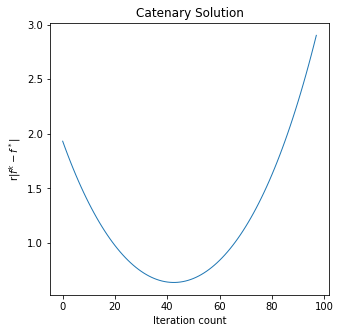

In [314]:
plt.plot(history[-1], linewidth=1)
plt.title('Catenary Function Solution')
plt.xlabel('Iteration count')
plt.ylabel('r$|f^k - f^*|$')
plt.show()